## Things to try still
* Is it possible to subsample tips from the tree within 
ipcoal demography to replicate sampling only some lineages within the local community?

In [1]:
%load_ext autoreload
%autoreload 2
import toytree
import ipcoal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from itertools import combinations

import sys
sys.path.append('/home/isaac/proj/IMEMEBA-BCI')
import BCI


In [3]:
tre = toytree.rtree.unittree(10, treeheight=1e7)
tre.draw(tree_style='p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="300.0px" viewBox="0 0 300.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tcc8370f7e650466692bf3b86b30e1261"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 0 5000000 10000000

## Unittree with constant Ne of 1e5

In [4]:
outphy = "./analysis/sim_fastas/unittree-Ne1e5-10samples.phy"
model = ipcoal.Model(tre, Ne=1e5, recomb=0, mut=1e-8, nsamples=10)
model.sim_loci(nloci=1, nsites=1000)
model.write_concat_to_phylip(name=outphy)
_ = BCI.phylip_to_fasta(outphy, verbose=False)

wrote concat locus (100 x 1000bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/analysis/sim_fastas/unittree-Ne1e5-10samples.phy


[61, 11, 11, 10, 9, 9, 9, 8, 8, 8, 8, 7, 6, 5, 4, 4, 4, 3, 2, 2]
Aligning..
{'r8_0': 0.004933333333333334, 'r5_0': 0.003800000000000001, 'r0_0': 0.0005555555555555556, 'r2_0': 0.0014000000000000002, 'r3_0': 0.007241269841269845, 'r9_0': 0.0038000000000000004, 'r4_0': 0.0038222222222222234, 'r6_0': 0.002711111111111111, 'r1_0': 0.003822222222222223, 'r7_0': 0.0021111111111111113}


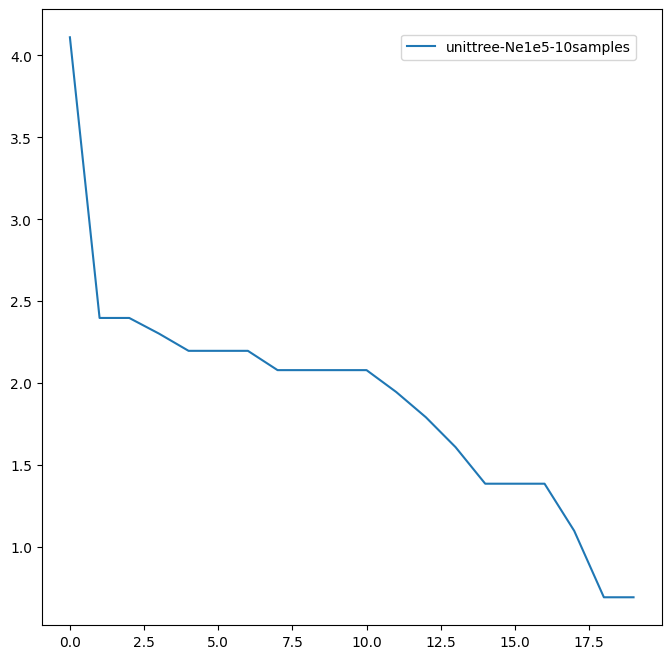

In [16]:
bci = BCI.BCI(data="./analysis/sim_fastas/unittree-Ne1e5-10samples.fasta")
bci.run(simulated=True, verbose=True)
print(bci.pis)
fig, ax = bci.plot(log=True, normalize=False)

## Unittree with lognormal NE and ancestral Ne of 1e5

In [265]:
outphy = "./analysis/sim_fastas/unittree-NeLognormal-10samples.phy"

np.random.lognormal(12, sigma=2, size=8)
tips = tre.get_tip_labels()
# Dict {tip_name:Ne}
Nes = {x:np.round(y) for x, y in zip(tips, np.random.lognormal(13, sigma=2, size=len(tips)))}
print(Nes)
# Set Nes for the tips
tre = tre.set_node_data("Ne", Nes, default=1e5)
# Set Ne to None here to honor the Ne values on the nodes of the tree
model = ipcoal.Model(tre, Ne=None, recomb=0, mut=1e-8, nsamples=10)
model.sim_loci(nloci=1, nsites=500)
model.write_concat_to_phylip(outdir=".", name=outphy)
BCI.phylip_to_fasta(outphy, verbose=True)


{'r0': 8290635.0, 'r1': 179107.0, 'r2': 167586.0, 'r3': 1466795.0, 'r4': 160654.0, 'r5': 34834.0, 'r6': 43787.0, 'r7': 753848.0, 'r8': 32144.0, 'r9': 139535.0}
wrote concat locus (100 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/analysis/sim_fastas/unittree-NeLognormal-10samples.phy
./analysis/sim_fastas/unittree-NeLognormal-10samples.fasta


'./analysis/sim_fastas/unittree-NeLognormal-10samples.fasta'

In [266]:
bci2 = BCI.BCI(data="./analysis/sim_fastas/unittree-NeLognormal-10samples.fasta")
bci2.run(verbose=True)

[53, 28, 22, 18, 16, 16, 14, 13, 13, 13, 10, 10, 9, 7, 5, 5, 3, 2, 2, 2]


## Plot them both together

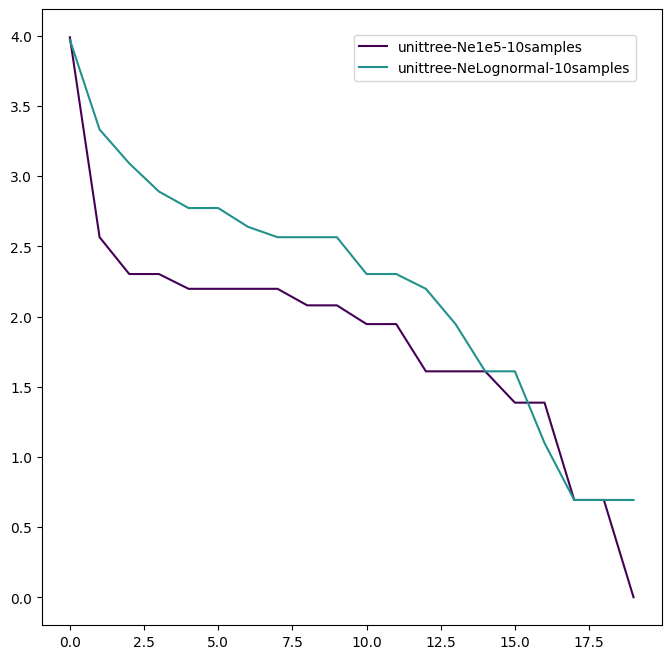

In [267]:
fix, ax = BCI.plot_multi([bci, bci2], log=True, normalize=False, cmap="viridis")

## Simulate trees with variable numbers of tips and demographic models with variable Ne

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy


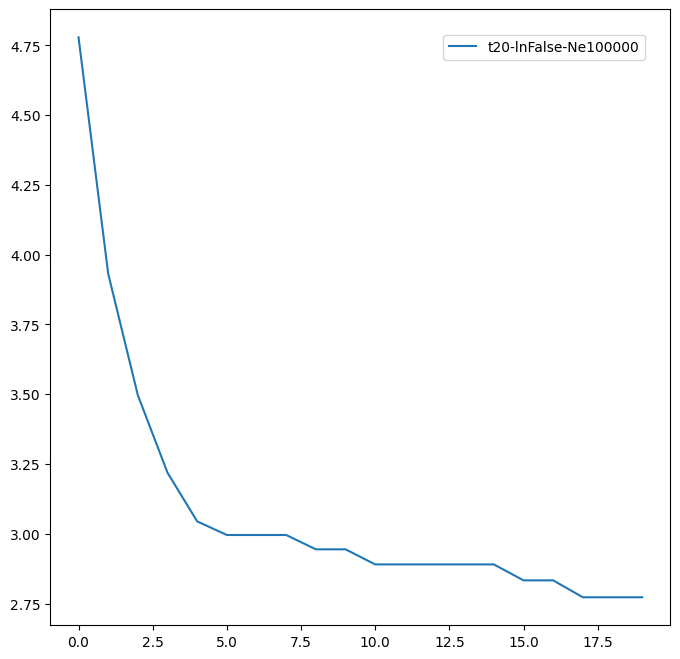

In [226]:
def sim_bci(ntips=8, treeheight=1e7, Ne=1e5, mutation_rate=3e-8, Ne_lognormal=False, verbose=False):
    """
    ntips - number of leaves on the simulated tree
    treeheight - Age of MRCA
    Ne - Ancestral Ne at all the nodes internal nodes
    mutation_rate - per base per generation mutation rate
    Ne_lognormal - Ne at the tips, can be a fixed value or 'lognormal' to indicate sampled from a lognormal distribution
    """
    tre = toytree.rtree.unittree(ntips, treeheight=treeheight)

    if Ne_lognormal:
        np.random.lognormal(12, sigma=2, size=8)
        tips = tre.get_tip_labels()
        # Dict {tip_name:Ne}
        Nes = {x:np.round(y) for x, y in zip(tips, np.random.lognormal(10, sigma=3, size=len(tips)))}
        if verbose: print(Nes)
        # Set Nes for the tips
        tre = tre.set_node_data("Ne", Nes, default=Ne)
        # Set Ne to None here to honor the Ne values on the nodes of the tree
        Ne_anc = Ne
        Ne = None
    else:
        # Use the same Ne for all nodes in the tree
        Ne_anc = Ne

    model = ipcoal.Model(tre, Ne=Ne, recomb=0, mut=mutation_rate, nsamples=10)
    model.sim_loci(nloci=1, nsites=500)
    # Write the sequence data to a file and conver to fasta
    outphy = f"t{ntips}-ln{Ne_lognormal}-Ne{str(Ne_anc)}.phy"
    model.write_concat_to_phylip(outdir=".", name=outphy)
    fasta = BCI.phylip_to_fasta(outphy, verbose=verbose)
    bci = BCI.BCI(data=fasta)
    bci.run(verbose=verbose)
    return bci

bci = sim_bci(ntips=20, Ne=1e5, verbose=False, Ne_lognormal=False)
fix, ax = bci.plot(log=True, normalize=False)

In [202]:
bci.bci

[100, 49, 36, 34, 25, 21, 15, 10, 8, 7, 4, 4, 4, 3, 3, 3, 2, 2, 1, 1]

## Same demography, constant Ne, same number of tips (20)

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

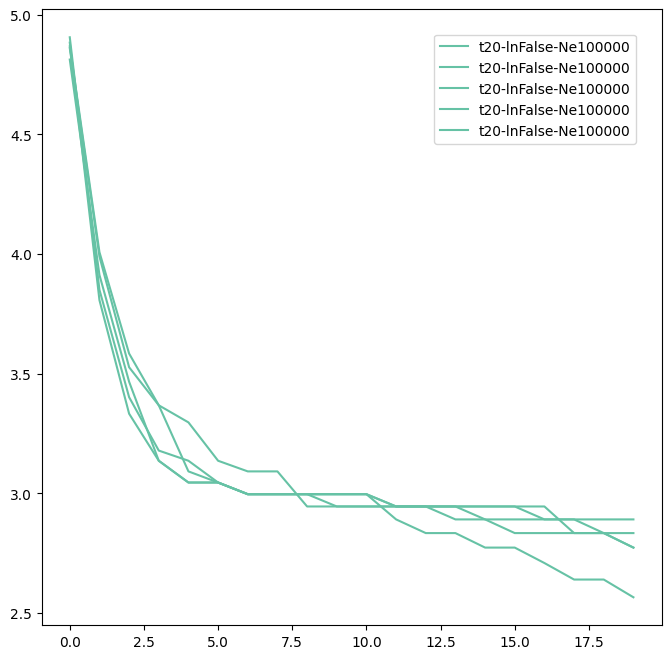

In [227]:
bcis = [sim_bci(ntips=20) for x in range(5)]
BCI.plot_multi(bcis, log=True, normalize=False)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

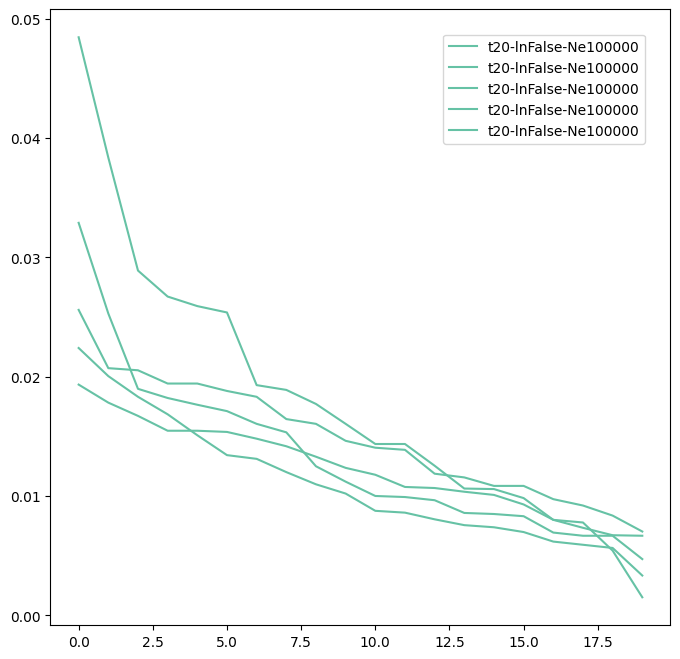

In [228]:
BCI.plot_multi(bcis, normalize=False, plot_pis=True)

## Same demography, lognormal Ne, same number of tips (20)

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

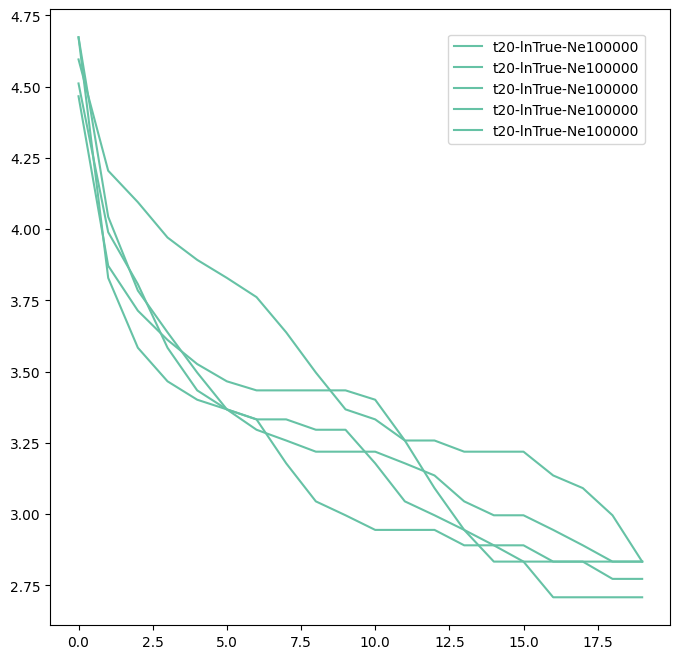

In [229]:
bcis = [sim_bci(ntips=20, Ne_lognormal=True) for x in range(5)]
BCI.plot_multi(bcis)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

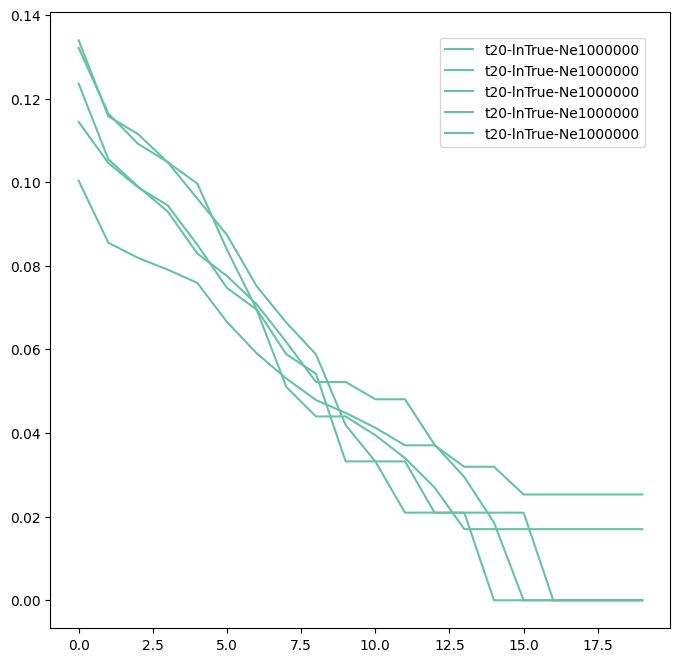

In [210]:
BCI.plot_multi(bcis, normalize=True)

## Same demography, constant Ne, but different numbers of tips from 10 - 100

wrote concat locus (100 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t10-lnFalse-Ne100000.0.phy
wrote concat locus (320 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t32-lnFalse-Ne100000.0.phy
wrote concat locus (550 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t55-lnFalse-Ne100000.0.phy
wrote concat locus (770 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t77-lnFalse-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnFalse-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

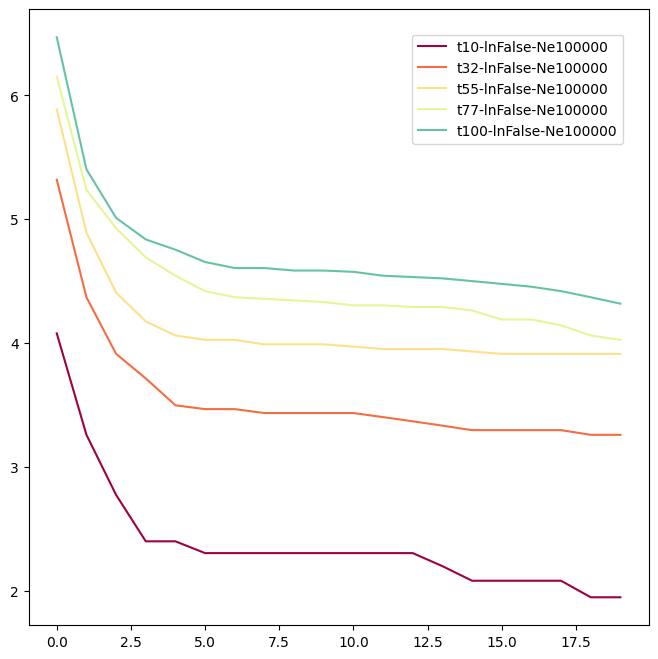

In [230]:
bcis = [sim_bci(ntips=int(x), mutation_rate=3e-8) for x in np.linspace(10, 100, 5)]
BCI.plot_multi(bcis)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

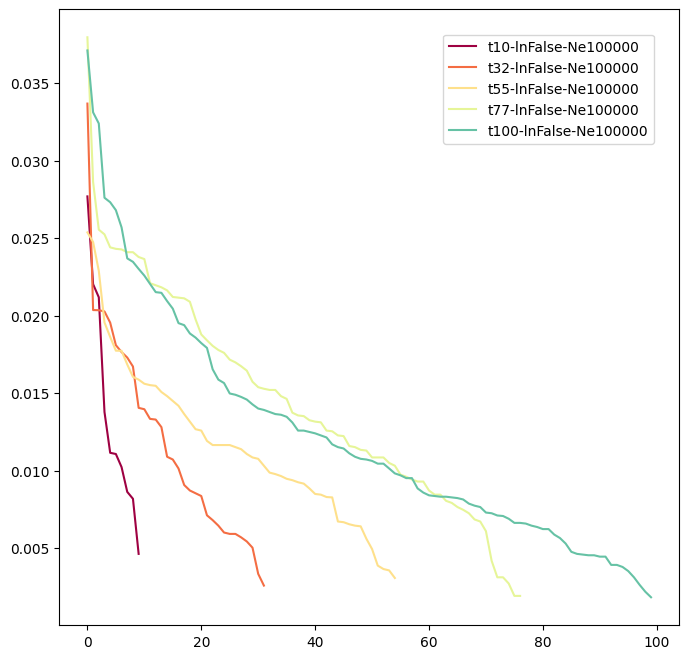

In [231]:
BCI.plot_multi(bcis, normalize=False, plot_pis=True)

## Same demography, lognormal Ne, but different numbers of tips from 10 - 100

wrote concat locus (100 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t10-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t20-lnTrue-Ne100000.0.phy
wrote concat locus (300 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t30-lnTrue-Ne100000.0.phy
wrote concat locus (400 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t40-lnTrue-Ne100000.0.phy
wrote concat locus (500 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t50-lnTrue-Ne100000.0.phy
wrote concat locus (600 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t60-lnTrue-Ne100000.0.phy
wrote concat locus (700 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t70-lnTrue-Ne100000.0.phy
wrote concat locus (800 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t80-lnTrue-Ne100000.0.phy
wrote concat locus (900 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t90-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t100-lnTrue-Ne100000.0.phy


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

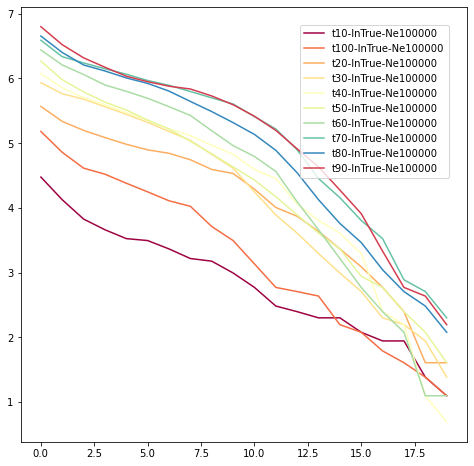

In [118]:
bcis = [sim_bci(ntips=int(x), Ne_lognormal=True) for x in np.linspace(10, 100, 10)]
BCI.plot_multi(bcis)

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

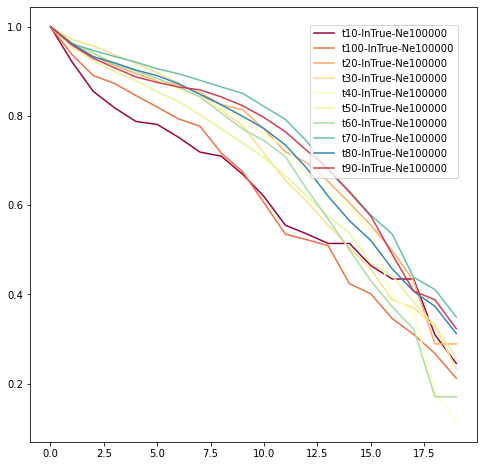

In [119]:
BCI.plot_multi(bcis, normalize=True)

## Same demography, lognormal Ne, 20 tips, varying Ne

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne10000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne119998.88888888889.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne229997.77777777778.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne339996.6666666667.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne449995.55555555556.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne559994.4444444445.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne669993.3333333334.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne779992.2222222222.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BC

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

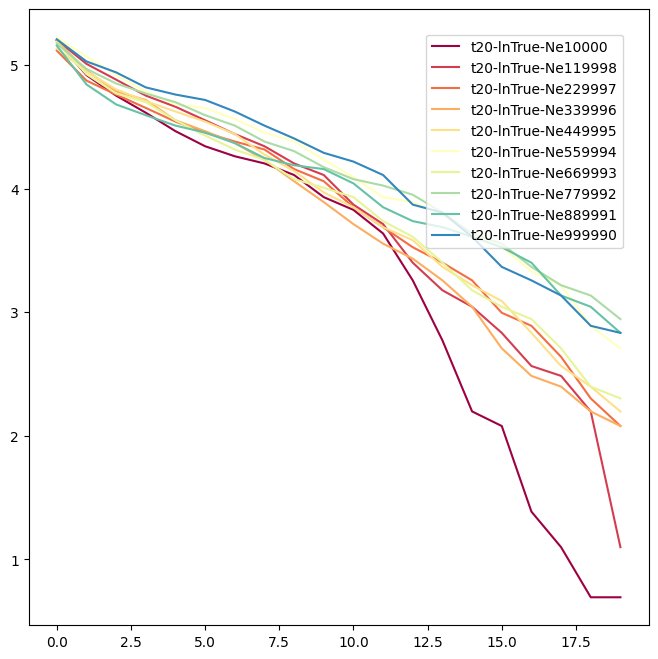

In [21]:
bcis = [sim_bci(ntips=20, Ne_lognormal=True, Ne=x) for x in np.linspace(1e4, 1e6-10, 10)]
BCI.plot_multi(bcis)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

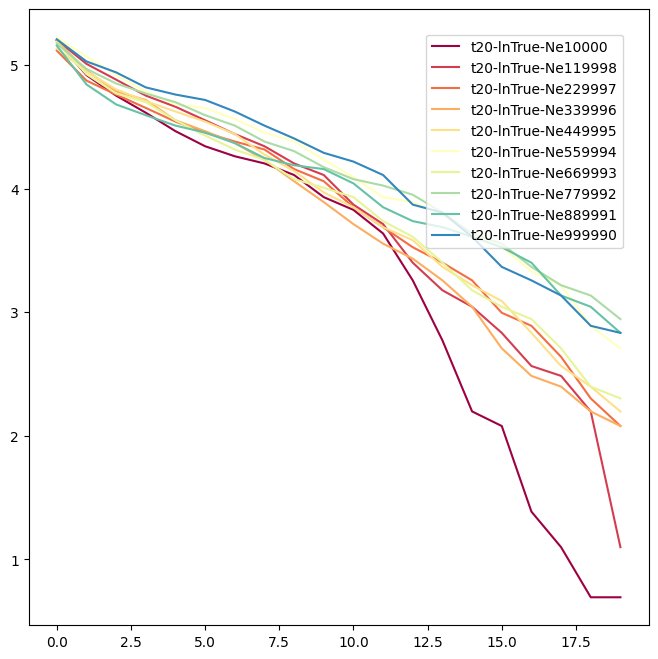

In [26]:
BCI.plot_multi(bcis, log=True, normalize=False)

In [ ]:
### Lets add more replicates to that

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne10000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne120000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne230000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne340000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne450000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne560000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne670000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne780000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne890000.0-lnTrue.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA/t20-lnTrue-Ne1000000.0-lnTrue.phy


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

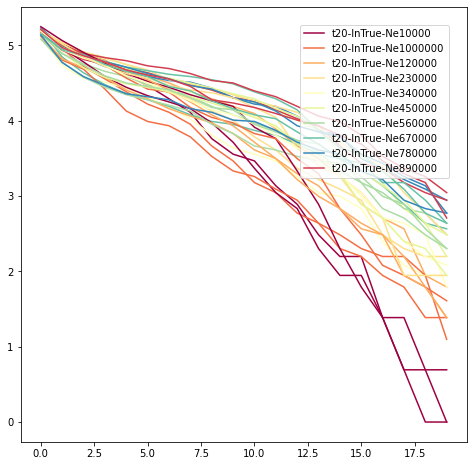

In [222]:
bcis.extend([sim_bci(ntips=20, Ne_lognormal=True, Ne=x) for x in np.linspace(1e4, 1e6, 10)])
BCI.plot_multi(bcis)

5
t20-lnTrue-Ne100000.0.fasta
dict_values([0.15297460317460343, 0.034901587301587295, 0.10086190476190483, 0.11794444444444467, 0.19227142857142906, 0.1992603174603179, 0.03353809523809522, 0.2143793650793657, 0.015866666666666668, 0.18995238095238115, 0.2797015873015876, 0.14342698412698449, 0.1727698412698416, 0.01443333333333334, 0.19628571428571454, 0.05531587301587293, 0.06882698412698414, 0.0845174603174603, 0.009911111111111114, 0.029365079365079354])
t20-lnTrue-Ne100000.0.fasta
dict_values([0.15297460317460343, 0.034901587301587295, 0.10086190476190483, 0.11794444444444467, 0.19227142857142906, 0.1992603174603179, 0.03353809523809522, 0.2143793650793657, 0.015866666666666668, 0.18995238095238115, 0.2797015873015876, 0.14342698412698449, 0.1727698412698416, 0.01443333333333334, 0.19628571428571454, 0.05531587301587293, 0.06882698412698414, 0.0845174603174603, 0.009911111111111114, 0.029365079365079354])
t20-lnTrue-Ne100000.0.fasta
dict_values([0.15297460317460343, 0.034901587301

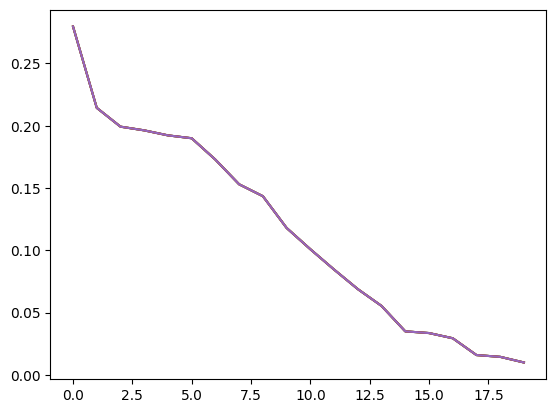

In [90]:
print(len(bcis))
list(map(lambda x: x.nucleotide_diversity(), bcis))
for bci in bcis:
    print(bci.data)
    print(bci.pis.values())
    plt.plot(sorted(bci.pis.values(), reverse=True))

# Prototyping

In [226]:
tips = tre.get_tip_labels()
# Dict {tip_name:Ne}
samps = [5]*8
Nes = {x:np.round(y) for x, y in zip(tips, samps)}
Nes

{'r0': 5, 'r1': 5, 'r2': 5, 'r3': 5, 'r4': 5, 'r5': 5, 'r6': 5, 'r7': 5}

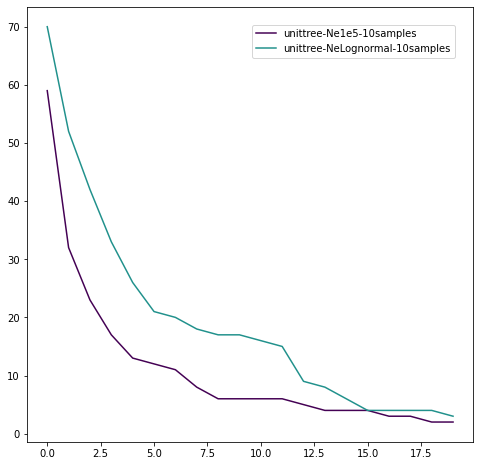

In [157]:
_ = BCI.plot_multi([bci, bci2], log=False, normalize=False, cmap="viridis")

In [167]:

def auc(bci, log=False, norm=False, verbose=False):
    d = np.array(bci.bci)
    if log: d = np.log(d)
    if norm: d = d/np.sum(d)
    if verbose: print(d)
    return np.trapz(y=bci.tols, x=d[::-1])
#    return np.trapz(y=np.arange(len(d)), x=d)
print(bci.samp, auc(bci, log=False, verbose=True))
print(bci2.samp, auc(bci2, log=False, verbose=True))

[59 32 23 17 13 12 11  8  6  6  6  6  5  4  4  4  3  3  2  2]
unittree-Ne1e5-10samples 47.257894736842104
[70 52 42 33 26 21 20 18 17 17 16 15  9  8  6  4  4  4  4  3]
unittree-NeLognormal-10samples 56.71052631578948


In [110]:
from scipy.stats import entropy
print(entropy(bci.bci, bci2.bci, base=2))
print(entropy(bci2.bci, bci.bci, base=2))

0.10646423731198598
0.09910060278524503


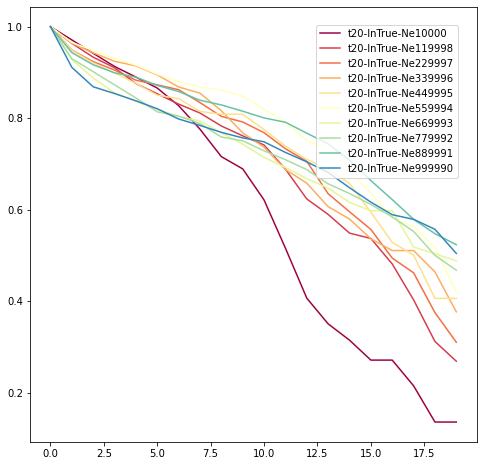

In [133]:
_ = BCI.plot_multi(bcis, log=True, normalize=True)

In [143]:
#auc(bcis[6], verbose=True)
for b in bcis:
    print(b.samp, auc(b, log=True))

t20-lnTrue-Ne10000 0.6549146427199043
t20-lnTrue-Ne119998 0.41118582185941593
t20-lnTrue-Ne229997 0.35941150355874363
t20-lnTrue-Ne339996 0.3474711624518364
t20-lnTrue-Ne449995 0.333768409067983
t20-lnTrue-Ne559994 0.26290197992522496
t20-lnTrue-Ne669993 0.36376609694824213
t20-lnTrue-Ne779992 0.35202273538712936
t20-lnTrue-Ne889991 0.2662400608496355
t20-lnTrue-Ne999990 0.3390159899193024


In [126]:
entropy(bcis[0].bci, bcis[6].bci, base=2)
#entropy(bcis[0].bci, np.ones(len(bcis[0].bci)), base=2)

0.1573007987544402

In [156]:
bcis_cyp = [sim_bci(ntips=100, Ne_lognormal=True, Ne=1e5, mutation_rate=1e-8, treeheight=1e7) for x in np.linspace(1e4, 1e6-10, 5)]


wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

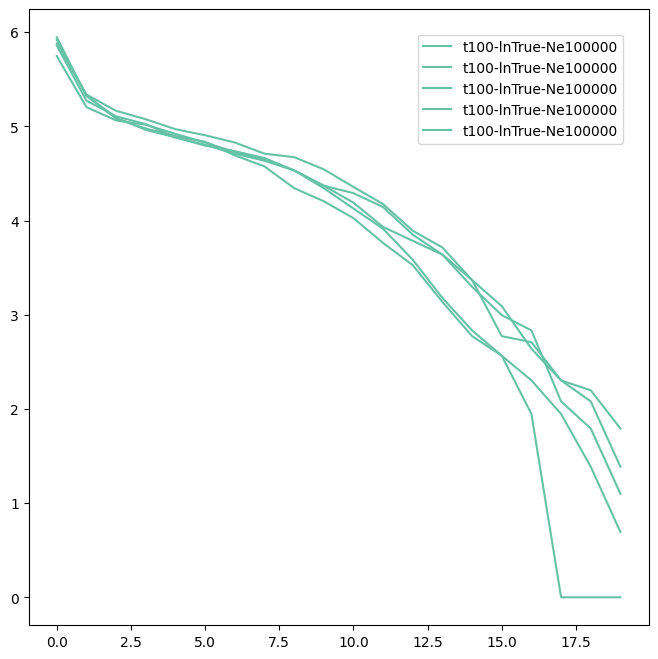

In [160]:
BCI.plot_multi(bcis_cyp, plot_pis=False)
#bcis_cyp[0].bci

In [145]:
{x:np.round(y) for x, y in zip(tips, np.random.lognormal(10, sigma=3, size=len(tips)))}

{'r0': 641.0,
 'r1': 522.0,
 'r2': 2227.0,
 'r3': 178391.0,
 'r4': 481.0,
 'r5': 91492604.0,
 'r6': 1823.0,
 'r7': 32574.0,
 'r8': 75883.0,
 'r9': 1575539.0}

In [17]:
print(bci.pis)
print(bci.sim_pis)

{'r8_0': 0.004933333333333334, 'r5_0': 0.003800000000000001, 'r0_0': 0.0005555555555555556, 'r2_0': 0.0014000000000000002, 'r3_0': 0.007241269841269845, 'r9_0': 0.0038000000000000004, 'r4_0': 0.0038222222222222234, 'r6_0': 0.002711111111111111, 'r1_0': 0.003822222222222223, 'r7_0': 0.0021111111111111113}
{'r6': 0.002711111111111111, 'r4': 0.0038222222222222234, 'r8': 0.004933333333333334, 'r7': 0.0021111111111111113, 'r3': 0.007241269841269845, 'r9': 0.0038000000000000004, 'r1': 0.003822222222222223, 'r0': 0.0005555555555555556, 'r5': 0.003800000000000001, 'r2': 0.0014000000000000002}
